In [206]:
#from pylab import *
import numpy as np
from numpy import linalg as LA
from scipy.stats import chi2
from mpl_toolkits.basemap import Basemap

import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

%matplotlib inline

*Define some parameters for the analysis*

In [272]:
# database to hit
hostname = 'mrtee.europa.renci.org'
username = 'bblanton'
password = 'dVork90*'
database = 'hurr_err'
table    = 'errorsV4'

FCastHours=np.array([24,48,72,96])
nfc=FCastHours.size

# SELECT constraints
YStart=2011
YEnd=2015
Model='HWRF'

Build the query string

In [273]:
cols=['CY','YYYYMMDDHH','LatNS','LonEW','MSLP','TY','fYYYYMMDDHH','fTECH','fTAU','fVerfTime','fLatNS','fLonEW','E_AlongTrack','E_CrossTrack','E_TotalError']
# SELECT
p1 =','.join(map(str,cols)) 
# from table
p2 = "{} ".format(table)      
# constraint
p3 = "year(YYYYMMDDHH)>={} and year(YYYYMMDDHH)<={} and fTECH='{}' and (TY='TS' or TY='HU')".format(YStart, YEnd, Model)
q= "SELECT " + p1 + " from " + p2 + "where " + p3
print q

SELECT CY,YYYYMMDDHH,LatNS,LonEW,MSLP,TY,fYYYYMMDDHH,fTECH,fTAU,fVerfTime,fLatNS,fLonEW,E_AlongTrack,E_CrossTrack,E_TotalError from errorsV4 where year(YYYYMMDDHH)>=2011 and year(YYYYMMDDHH)<=2015 and fTECH='HWRF' and (TY='TS' or TY='HU')


In [274]:
myConnection = mysql.connector.connect( host=hostname, user=username, passwd=password, db=database )
cur = myConnection.cursor()

In [275]:
cur.execute(q) 

In [276]:
data = cur.fetchall()

It'll be much easier to work with the data if it's in a pandas DataFrame

In [277]:
df = pd.DataFrame(data, columns=cols)

Here's a plot of all the errors, colored by MSLP, sized by TAU

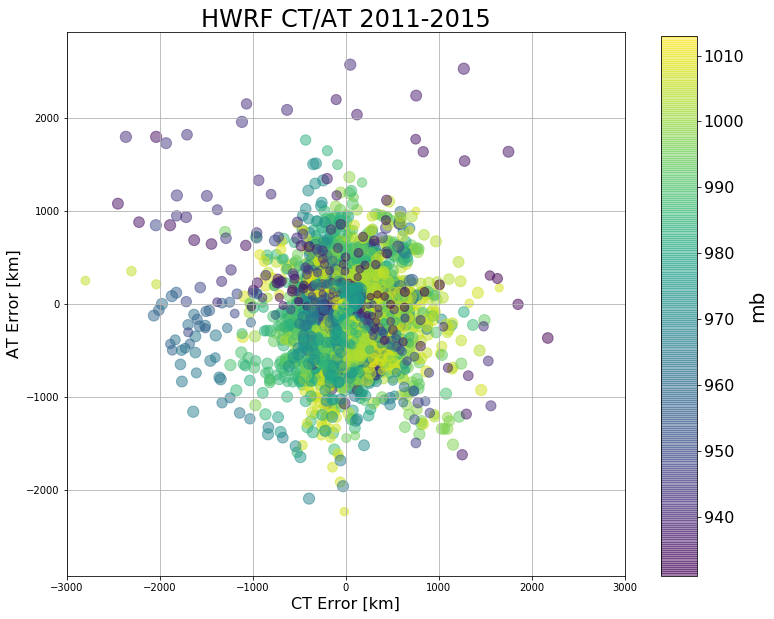

In [318]:
fig=plt.figure(figsize=(10,10))
plt.axis('equal')
plt.grid('on')
pc=plt.scatter(x=df.E_CrossTrack,y=df.E_AlongTrack,s=df.fTAU,c=df.MSLP, alpha=0.5)
plt.axis(np.array([-1, 1, -1, 1])*3000)
plt.title('{} CT/AT {}-{}'.format(Model,YStart,YEnd),fontsize=24)
plt.xlabel('CT Error [km]',fontsize=16)
plt.ylabel('AT Error [km]',fontsize=16)

cbax = fig.add_axes([.95, .125, .05, .75]) 
cb = plt.colorbar(pc, cax=cbax, orientation='vertical')
cb.set_label('mb', fontsize=20)
cb.ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('{}.CTAT.png'.format(Model), bbox_inches='tight',dpi=200)

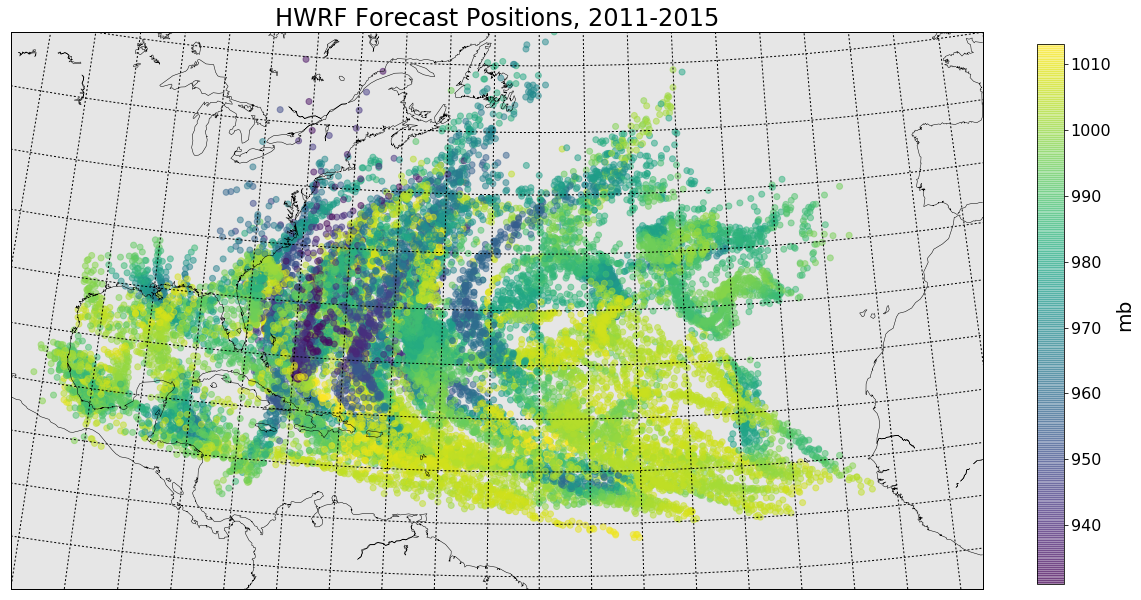

In [292]:
llcrnrlon=-100    # lower-left corner, lon
llcrnrlat=  0    # lower-left corner, lat
urcrnrlon= 0    # upper-right corner, lon
urcrnrlat=  50    # upper-right corner, lat
lon_0   =-50      # center of desired map domain (in degrees).
lat_1   =10      # first standard parallel for lambert conformal
latmn = np.mean(df.fLatNS)


fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0.05,0.05,0.9,0.9])
m = Basemap(llcrnrlon=llcrnrlon,
            llcrnrlat=llcrnrlat, 
            urcrnrlon=urcrnrlon,
            urcrnrlat=urcrnrlat, 
            projection='lcc',
            resolution ='l',
            area_thresh=1000.,
            lat_1=lat_1,
            lon_0=lon_0)
ax.set_aspect(1.0/np.cos(latmn * np.pi / 180.0))

m.drawmapboundary(fill_color='0.9')
m.drawcoastlines(linewidth=.5)
m.drawparallels(np.arange(-90.,99.,5.))
m.drawmeridians(np.arange(-180.,180.,5.))
plt.title('{} Forecast Positions, {}-{}'.format(Model,YStart,YEnd),fontsize=24)

x,y=m(df.fLonEW.values,df.fLatNS.values)
pc=ax.scatter(x=x,y=y,c=df.MSLP, alpha=0.5)
cbax = fig.add_axes([1, 0.12, 0.025, 0.75]) 
cb = plt.colorbar(pc, cax=cbax,  orientation='vertical')
cb.set_label('mb', fontsize=20)
cb.ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('{}.LonLatMSLP.png'.format(Model), bbox_inches='tight',dpi=200)

#plt.axis([-2000, 2000, -2000, 2000])
#plt.xlabel('CT Error [km]')
#plt.ylabel('AT Error [km]')

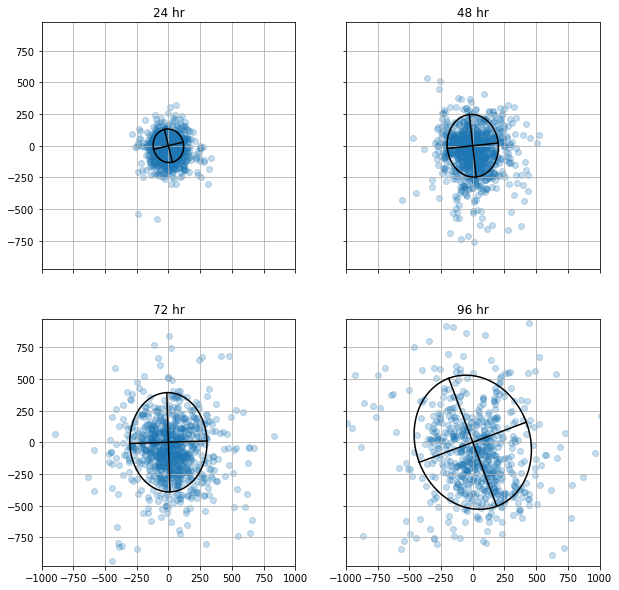

In [321]:
f, axx = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

#flatten 2-d array for 1-d indexing
axx=axx.flatten()

conf=.667
k=chi2.ppf(conf,2)
t=np.arange(0,2*np.pi,np.pi/180)
plt.title('xxx')

for i in range(0,nfc):
    idx=df.fTAU==FCastHours[i]
    eigval,eigvec=LA.eig(np.cov(df.E_CrossTrack[idx],df.E_AlongTrack[idx]))
    eigval=np.expand_dims(eigval,axis=0)
    p1=np.transpose(np.array([np.cos(t), np.sin(t)]))
    p2=p1*np.sqrt(eigval)
    xy=np.dot(p2,np.transpose(eigvec))
    xy=xy*np.sqrt(k)
    
    axx[i].scatter(x=df.E_CrossTrack[idx],y=df.E_AlongTrack[idx],alpha=0.25)
    axx[i].axis('equal')
    axx[i].grid('on')
    axx[i].axis([-1000, 1000, -1000, 1000])
    axx[i].set_title('{} hr'.format(FCastHours[i]))
    axx[i].plot(xy[:,0],xy[:,1],c='k') 
    axx[i].plot([xy[0,0],xy[180,0]],[xy[0,1],xy[180,1]],c='k') 
    axx[i].plot([xy[90,0],xy[270,0]],[xy[90,1],xy[270,1]],c='k') 

Let's compute variance ellipses. 
The ellipse major,minor axes are the eigenvalues of the covairance matrix.

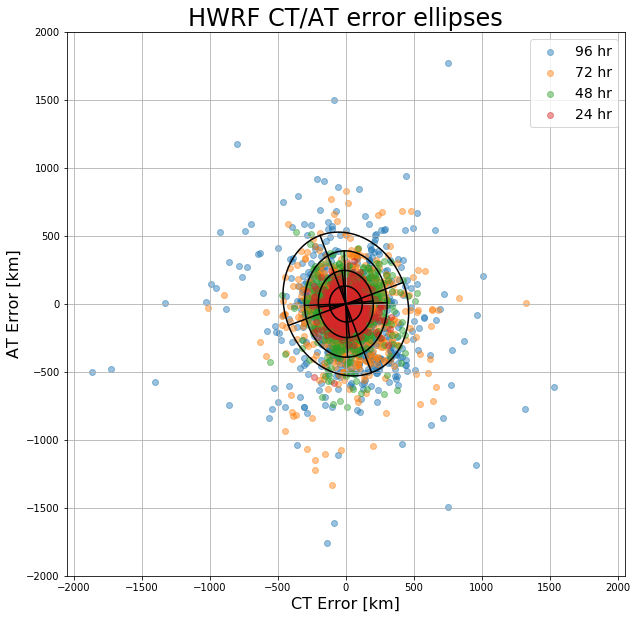

In [328]:
# define the scaled size of the ellipses
plt.figure(figsize=(10,10))

for i in range(nfc-1,-1,-1):
    idx=df.fTAU==FCastHours[i]
    eigval,eigvec=LA.eig(np.cov(df.E_CrossTrack[idx],df.E_AlongTrack[idx]))
    eigval=np.expand_dims(eigval,axis=0)
    p1=np.transpose(np.array([np.cos(t), np.sin(t)]))
    p2=p1*np.sqrt(eigval)
    xy=np.dot(p2,np.transpose(eigvec))
    xy=xy*np.sqrt(k)
    plt.scatter(x=df.E_CrossTrack[idx],y=df.E_AlongTrack[idx],alpha=.45,label='{} hr'.format(FCastHours[i]))
    plt.plot(xy[:,0],xy[:,1],c='k') 
    plt.plot([xy[0,0],xy[180,0]],[xy[0,1],xy[180,1]],c='k') 
    plt.plot([xy[90,0],xy[270,0]],[xy[90,1],xy[270,1]],c='k') 
    
plt.axis('equal')
plt.grid(True)
plt.axis(np.array([-1, 1, -1, 1])*2000)
plt.title('{} CT/AT error ellipses'.format(Model),fontsize=24)
plt.xlabel('CT Error [km]',fontsize=16)
plt.ylabel('AT Error [km]',fontsize=16)
plt.legend(fontsize=14)
plt.savefig('{}.ErrorEllipses.png'.format(Model), bbox_inches='tight',dpi=200)